# Analysis of crime data in Toronto

In [ ]:
# Optional step - Installing required packages
!pip install geopandas pysal libpysal 

### Loading data
> First, I have accessed the [Robbery API](https://data.torontopolice.on.ca/datasets/TorontoPS::robbery-1/explore?location=19.913172%2C-39.955912%2C4.42) from [Toronto Police](https://data.torontopolice.on.ca/search?tags=crime) website.  Then I have filtered out the robberies that happened from December 2021 to May 2022 i.e 6 months. 
>
> The API URL with filter queries is [Filtered Data](https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/Robbery/FeatureServer/0/query?where=reporteddate%20BETWEEN%20%272021-12-01%27%20AND%20%272022-06-30%27&outFields=*&f=geojson). This can be opened in a browser to check for output as HTML document but the data is in geojson.
>


In [ ]:
# Importing the required packages
import requests     
import pandas as pd      
import geopandas as gpd
import sklearn as sk
from shapely.geometry import Point

# To display all the columns whenever .head() is used which can be used to pre-process data.
pd.options.display.max_columns = None

> To make it readable and clean, we will put the query part in a params variable with all the filters.
>
> Using the [requests](https://requests.readthedocs.io/en/latest/api/) library, we will pass the URL and its params to get the response. 200 OK is the response we will need to proces data.
>
> The type of response is  *requests.models.Response*. 
>Firstly, I checked if the response is 200 and then converted the output in json dict.

In [ ]:
# Set API endpoint
url = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/Major_Crime_Indicators/FeatureServer/0/query"

# Using params variable for the filtered queries
params = {
    "where": "occurrencedate BETWEEN '2021-01-01' AND '2022-06-01'",
    "outFields": "*",
    "f": "json"
}

# Send GET request to API to get the response
response = requests.get(url, params=params)

In [ ]:
# Check if request was successful and print the data for verification
if response.status_code == 200:
    # Retrieve crime data from response
    data = response.json()    
else:
    print("Error: Request failed with status code", response.status_code)

### Pre-processing the data

> The data needs to be in Pandas DataFrame format that can be read and create kernel density maps. I preprocessed the data and selected only the columns of my interest.
> I dropped the columns which were not useful for analysis.

In [ ]:
# Using list comprehension to filter attributes 
crime_data = [attr['attributes'] for attr in data['features']]

# Converting the list into dataFrame
crime_data = pd.json_normalize(crime_data)

In [ ]:
# Dropping the columns which are not required.
crime_data.drop(['Index_','event_unique_id', 'Division','ucr_ext','ucr_code','reporteddayofyear', 'occurrencedayofyear', 'ObjectId'], axis=1, inplace=True)

## Part A

#### **1. Are the crimes clustered? Is there Central Tendency? Create a density map showing the local density (quadrat or kernel method may be used) and describe the results (< 100 words).**
> I am using Seaborn for data visualization and matplotlib for  creating highly customizable plots.

In [ ]:
import seaborn as sns       # For data visualization 
import matplotlib.pyplot as plt   # For plotting
import folium     # For mapping crime on the map
from folium.plugins import HeatMap, MarkerCluster  # For visually appealing map

> To make it easier to plot, I have converted the "mci_category" column in the "crime_data" dataframe into a categorical data type, which can be useful for certain types of analysis.
>
>I have then grouped the crime_data dataframe by neighborhood and counts the number of occurrences of each type of crime in each neighborhood using the "count" method. The resulting dataframe is then sorted in ascending order based on the number of crimes in each neighborhood using the "sort_values" method.
>
> I have selected the "Neighbourhood", "Latitude", and "Longitude" columns from the "crime_data" dataframe and dropped any duplicate neighborhood names(if any) using the "drop_duplicates" method. The resulting dataframe is then indexed by neighborhood and joined with the previously computed count of crimes by neighborhood.
>
> Finally, I have sorted the dataframe in descending order based on the count of crimes in each neighborhood and selected the top 10 neighborhoods with the most crimes using the "head" method. This step displays the table. *This step is optional.*


In [ ]:
# To make mci_category column as category type
crime_data["mci_category"] = crime_data["mci_category"].astype('category')

# Top Criminal Neighbourhoods in Toronto 
top = crime_data.groupby('Neighbourhood')[['mci_category']].count().sort_values(by=['mci_category'])

# Coordinates Criminal Neighbourhoods
map_data = crime_data[['Neighbourhood', 'Latitude', 'Longitude']].drop_duplicates('Neighbourhood').set_index('Neighbourhood').join(top, how='inner')

# Displays the top 10 neighbourhoods table
map_data.sort_values(by=['mci_category'], ascending=False).head(10)

Latitude  Longitude  mci_category
Neighbourhood                                                        
Church-Yonge Corridor              43.649262 -79.374106            45
Waterfront Communities-The Island  43.648812 -79.388886            36
West Humber-Clairville             43.731907 -79.596004            25
Moss Park                          43.649450 -79.371425            24
Woburn                             43.772141 -79.251457            23
Bay Street Corridor                43.655716 -79.383726            23
Willowdale East                    43.770993 -79.413275            22
Rosedale-Moore Park                43.672874 -79.387826            19
Downsview-Roding-CFB               43.720916 -79.508595            19
West Hill                          43.767583 -79.183234            15

> The resulting dataframe will be used to create visualizations such as a choropleth map to display the crime rates across different neighborhoods. 
>
> I am using Folium's HeatMap because it is useful when you want to create interactive density maps on top of a map background. It is easy to use and allows for customization of the heatmap appearance, such as the color scheme, opacity, and radius of the heatmap points. Folium HeatMap also supports clustering and zooming in and out of the map.
> But, there are other ways to plot a density map depending on the requirements like:
* Seaborn's kdeplot 
* Plotly's Density Maps 
* Basemap 
* Geopandas
* Scikit-learn's KDE
> 
> Using [Toronto Crime](https://www.jiristodulka.com/post/toronto-crime/) as reference, I have created a Folium map which overlays a heat map layer on top of it to display the density of crimes in Toronto. 
>
> * The code initializes a new Folium map centered at the coordinates [43.702270, -79.366074] with a zoom level of 11.
> * Then a MarkerCluster object is created to group together the individual crime locations on the map.
> * Creating & adding Marker for every row by iterating over the rows of the map_data DataFrame.
> * The maximum number of crimes in any neighborhood is computed from the map_data DataFrame, which is used as a reference for the darkest shade in the heat map layer.
> Lastly, the HeatMap object is added as a layer on top of the Folium map using the add_to() method. This displays the density of crimes in each neighborhood as a heat map layer on the map.

In [ ]:
# Mapping Criminal Neighbourhoods
heat_map = folium.Map(
    location=[43.702270, -79.366074],
    zoom_start=11,
)

#Step 1: Clusters
cluster = MarkerCluster().add_to(heat_map)

#Step 2: Clusters breaking into Markers
#for x in map_data.iterrows():
  #  folium.Marker([x[1].Latitude, x[1].Longitude]).add_to(cluster)

for x in map_data.iterrows():
    folium.Marker(
        [x[1].Latitude, x[1].Longitude], 
        popup=x[0]#.Neighbourhood
    ).add_to(cluster)

#Step 3: Heat
max_crime = map_data['mci_category'].max() # max value as reference for the darkets shade
heat = HeatMap(map_data.values,
                min_opacity=0.2,
                radius=30, blur=20, 
                max_zoom=15
                )

heat.add_to(heat_map)

heat_map

**Results**

> The heatmap is color-coded, with darker shades of red indicating higher crime density and lighter shades indicating lower crime density. The color scheme ranges from blue (lowest density) to red (highest density). The heatmap is interactive, allowing users to zoom in and out, and pan across the map to explore different areas of Toronto.
>
>The heatmap also includes clusters of markers that show the location of each neighborhood on the map. The clusters are color-coded based on the number of neighborhoods in each cluster, with larger clusters indicating more densely populated areas of the city. The markers provide additional information about each neighborhood, such as the name and location.
>
>The heatmap provides a visual representation of the distribution of criminal activities in Toronto and can be used to identify areas that may require increased policing or other interventions to address crime.
>
> The neighbourhood in red area is *Church-Yonge Corridor*. To confirm it, I have calculated the central tendency.



**Adding central tendency**
> To find the central tendency, mode has to be calculated (i.e., the most frequently occurring value) of the 'Neighbourhood' column in the 'crime_data' dataset.
>
> The marker is used to visually display the central tendency information on the map. 

In [ ]:
# Calculating mode value for neighbourhood column
central_tendency = crime_data['Neighbourhood'].mode()[0]

# Add popup with central tendency information
popup_text = "Central tendency based on neighbourhood: " + central_tendency
folium.Marker([43.7, -79.4], popup=popup_text).add_to(heat_map)

# Show the map to see the heat map with the central tendency
heat_map

> It can be seen from the map that the central tendency is on *Church-Yonge Corridor* neighbourhood which matches the density map.

#### **2. Are there spatial outliers or trends in the data you’ve selected? Discuss (include any tests run, figures, and maps generated) (200 - 400 words).**

In [ ]:
# Importing 
import regex as re

> To find spatial trends or outliers, I am using *premises_type* and *mci_category* from crime_data dataframe in the  first part. In second part,  I am filtering it to Assault from the *offence* against the *mci_category* column.

Part 2.1 - Pie chart visualization
>  Firstly, the count of each category of crime in the mci_category column of the crime_data dataframe using the *value_counts()* function. The keys() function is used to extract the category names from the *value_counts()* object.
>
> I have grouped the data in the crime_data dataframe by the premises_type column, summed up the number of crimes in each group using the *count()* functionand sorted the resulting series in descending order using sort_values()
>
> I also checked if any group has less than 10 crimes, and if so, renamed that group to "Other" using the *rename()* function. This is done to reduce the number of categories and make the resulting visualization more readable.
>
> The code groups the data in the *prem_counts* dataframe by the index (i.e., the premises_type column after any renaming has been done), sums the crime counts for each group using the sum() function, and sorts the resulting dataframe in descending order using sort_values().
>
> Finally, the index of the resulting dataframe is stored in the *labels_neighbourhood* variable, and the crime counts are flattened into a 1D array using the *values.flatten()* function and stored in the values_neighbourhood variable.


In [ ]:
# Values count and labels from the crime_data df
values_mci = crime_data["mci_category"].value_counts() 
labels_mci = crime_data["mci_category"].value_counts().keys()

prem_counts = crime_data.groupby('premises_type')['mci_category'].count().sort_values(ascending=False)

# Aggregrating data to reduce the number of categories which will make visualization easier
for key,value in prem_counts.iteritems():
  if value < 10:
    prem_counts = pd.DataFrame(prem_counts.rename({key: "Other"}))

# Grouping the data by the prem_counts index 
prem_counts=prem_counts.groupby(prem_counts.index).sum().sort_values("mci_category",ascending=False) #Step 4.

# Storing the index and flattening the values
labels_neighbourhood = prem_counts.index    
values_neighbourhood = prem_counts.values.flatten()

> Visualizing the data using pie charts for further analysis.

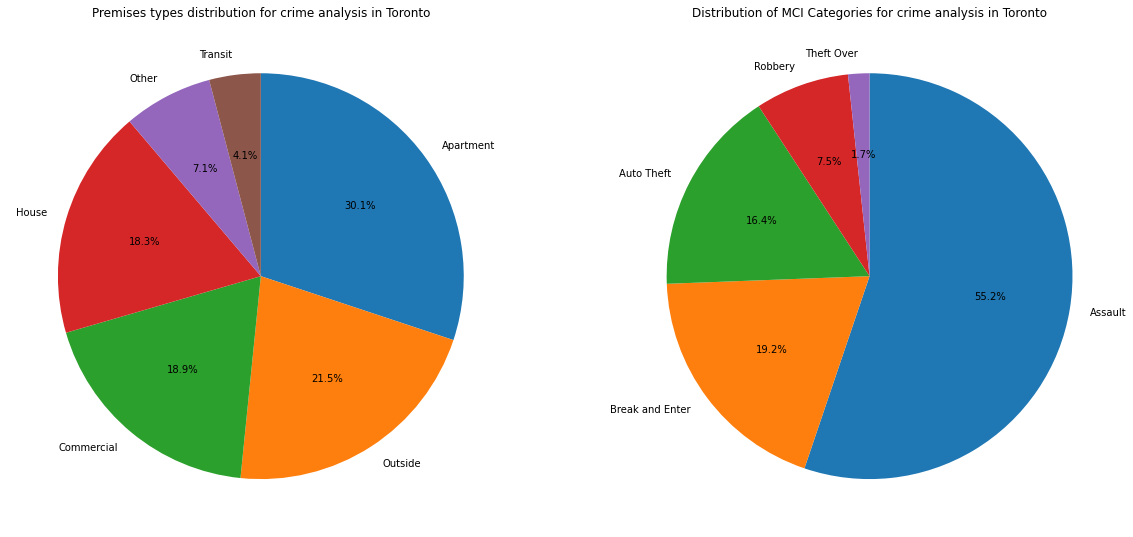

In [ ]:
# Set figure size and layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# Create the first pie chart and set title 
ax1.pie(values_neighbourhood, labels=labels_neighbourhood, autopct='%1.1f%%', startangle=90, counterclock=False)
ax1.set_title("Premises types distribution for crime analysis in Toronto")

# Create the second pie chart and set title
ax2.pie(values_mci, labels=labels_mci, autopct='%1.1f%%', startangle=90, counterclock=False)
ax2.set_title("Distribution of MCI Categories for crime analysis in Toronto")

# Display the pie charts
plt.show()

**Discussion**

> The first pie chart (on left) shows that the most common premises types for crime incidents are apartments, commercial establishments, and homes, accounting for more than 65% of the total incidents. The "Other" category, which includes less common premises types, accounts for around 7.1% of the incidents. 

> The second pie chart (right side) shows that the most common Major Crime Indicators (MCI) categories for crime incidents are Assault, Break and Enter, and Auto theft accounting for more than 90% of the total incidents. The "Other" category, which includes less common MCI categories, accounts for around 10% of the incidents.

> The trends that can be seen here is breaking and entering which correlate to Apartment and house premises. Auto theft is also common with breaking and entering a house. Assault seems to be more common in commercial places or in the public.

Part 2.2 - Histogram visualization
> The process is similar like part 2.1 with pie charts. The columns that   are chosen to visualize are mci_category and filtered Assault from 'offence' column. I have aggregrated data related to crime incidents of the "ASSAULT" category. 
>
> Firstly, the rows in the crime_data DataFrame are filtered out which contain the string "ASSAULT" in the offence column and assigns it to the crime_assault variable. *values_assault*, a new Series which counts the number of occurrences of each unique value in the offence column of the crime_assault DataFrame is created.
>
> I grouped it, if the count is less than 15 and renamed it to 'Other'. and grouped the DataFrame by the index values and the sum of the values for each group is computed using groupby() and sum() methods of pandas DataFrame.
>
> Finally, the resulting DataFrame is sorted in descending order of the "offence" column and stored the index.


In [ ]:
# Values count and labels from the crime_data df
crime_assault = crime_data[crime_data["offence"].str.contains('ASSAULT', flags=re.IGNORECASE, regex=True)] 
values_assault = crime_assault["offence"].value_counts() 

# Aggregrating data to reduce the number of categories which will make visualization easier
for key,value in values_assault.iteritems(): #Step 3.
    if value < 15:
       values_assault= pd.DataFrame(values_assault.rename({key: "Other"}))

# Grouping the data by the values_assault index 
values_assault=values_assault.groupby(values_assault.index).sum().sort_values("offence",ascending=False) 

# Storing the index
labels_assault = values_assault.index 

> Visualizing the data using histogram for further analysis.

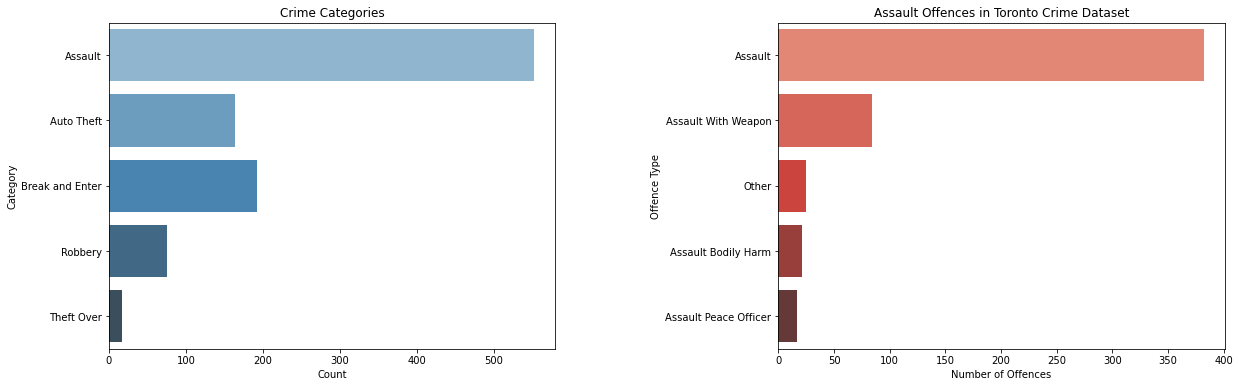

In [ ]:
# Set figure size and layout
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

# Create the first subplot, set title and axes labels
sns.barplot(x=values_mci,y=labels_mci,palette="Blues_d", ax=axes[0])
axes[0].set_title("Crime Categories")
axes[0].set_ylabel("Category")
axes[0].set_xlabel("Count")

# Create the second subplot, set title and axes labels
sns.barplot(x=values_assault['offence'], y=labels_assault, palette="Reds_d", ax=axes[1])
axes[1].set_title("Assault Offences in Toronto Crime Dataset")
axes[1].set_xlabel("Number of Offences")
axes[1].set_ylabel("Offence Type")

# Adjust spacing between subplots
fig.subplots_adjust(wspace=0.5)

plt.show()

**Discussion**

> In the first bar subplot (left side), it is evident that the most common category of crime is Assault which was discussed above. I used  offence column and filtered all rows with 'Assault' keyword to analyze the types.
>
> The shows the count of different types of assault offences in the dataset. The most common type of assault offence is "Assault", followed by "Assault with weapon". Assuming, 'Assault' offence is without a weapon. This means that usage of weapon is low and most of the 'assault' crimes happen without a weapon.
>
> Other 'Assault' offence types are relatively low in Toronto. 
>
> Overall, the analysis of the assault offences provides a deeper understanding of the crimes that fall under the assault category. It is essential to analyze the specific types of crimes within a category to understand the severity and frequency of the different types of crimes. The bar charts help to visually represent the count of each crime category, which can aid in identifying patterns and trends in the data.

## Part B

#### **3. What is the probability that this spatial pattern could have arisen by chance (Moran’s I)? (Include graphs and or text to support your answer.)**

In [ ]:
# Importing required packages
from libpysal.weights import DistanceBand
from esda.moran import Moran, Moran_Local
from sklearn.preprocessing import StandardScaler
from splot.esda import moran_scatterplot, plot_moran, plot_moran_simulation

> To calculate Moran's I on spatial data, it is recommended to use a GeoPandas dataframe, as it includes spatial data and specific functionalities for spatial analysis. 
>
> I have converted the crime_data pandas dataframe to a geopandas dataframe *'gdf'*. Columns which were required are selected and put in the same *'gdf'* variable.
>
> It then removes any duplicate neighbourhoods based on "Neighbourhood" column and sets the index to "Neighbourhood" and performs an inner join with the "top" dataframe which consists of top n neighbourhoods.

In [ ]:
# Create a new column 'geometry' to store Shapely Point objects from 'longitude' and 'latitude'
crime_data['geometry'] = crime_data.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(crime_data, geometry='geometry', crs='epsg:4326')

In [ ]:
# Selecting the columns which are required and resetting index
gdf = gdf[['Neighbourhood', 'Latitude', 'Longitude','geometry']].drop_duplicates('Neighbourhood').set_index('Neighbourhood').join(top, how='inner')
gdf = gdf.reset_index()

> The numerical columns "Latitude", "Longitude", and "mci_category" are standarized using sklearn's StandardScaler. This step scales the data to have zero mean and unit variance.
>
> Then, a spatial weights matrix "w" is created using the "*DistanceBand.from_dataframe()*"  function from PySAL. This function calculates a spatial weights matrix based on distances between points in the dataframe, and sets a distance threshold of 1000 units.
>
> It transforms the spatial weights matrix "*w*" using the "*Rook*" criterion. The Rook criterion specifies that two neighbouring areas share a border if they share an edge or a corner.


In [ ]:
# Standardize the data using sklearn's StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(gdf[['Latitude', 'Longitude', 'mci_category']])

# Create a spatial weights matrix based on distances between points
w = DistanceBand.from_dataframe(gdf, threshold=1000, binary=False)
w.transform = 'R'

/usr/local/lib/python3.9/dist-packages/scipy/sparse/_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


> *Moran()* calculates the global Moran's I statistic for the given attribute in X (in this case, the mci_category column after standardization), using the spatial weights matrix w. The result is stored in the mi object.
>
> *Moran_Local()* calculates the local Moran's I statistic for each feature in the mci_category column using the same spatial weights matrix w. The resulting values are stored in moran_loc_values.
> 
> *moran_scatterplot()* creates a scatterplot of the data, with the Moran's I values on the x-axis and the local Moran's I values on the y-axis. It also highlights any statistically significant spatial clusters.


In [ ]:
# Calculate Moran's I
mi = Moran(X[:,2], w)
print("Moran's I (global)",mi.I)

# Calculate local Moran's I for each feature
moran_loc = Moran_Local(gdf['mci_category'], w)

# Calculate local Moran's I for each feature
moran_loc_values = moran_loc.Is

Moran's I (global) 0.08008519028581117


> The Moran Scatterplot is a diagnostic tool for examining spatial autocorrelation in a dataset. It has two axes and a dashed line:
* x-axis: The standardized values of the variable being tested for spatial autocorrelation (i.e. Z-scores of the variable).
* y-axis: The spatial lag of the variable, which is a measure of how similar the variable values are among neighboring observations.
* The plot also includes a dashed line at the global mean of the feature value, which serves as a reference point for interpreting the scatterplot. 
>
>Each point on the scatterplot represents a pair of observations, with the x-coordinate representing the value of the variable for one observation and the y-coordinate representing the average value of the variable for that observation's neighbors. 

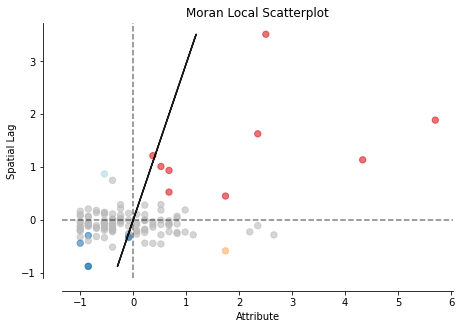

In [ ]:
# Create a Moran Scatterplot
fig, ax = moran_scatterplot(moran_loc, p=0.05)
plt.show()

> Finally, p_sim is calculated as the p-value associated with the global Moran's I statistic (mi.I), indicating the level of significance of the spatial autocorrelation in the data. 
>
> The p-value represents the probability that the observed spatial pattern of crime could have arisen by chance. If the p-value is less than 0.05, we can reject the null hypothesis that the spatial pattern is random and conclude that there is spatial autocorrelation in the data.

In [ ]:
# Calculate p_sim
p_sim = mi.p_sim

# Print p_sim
print("p_sim = ", p_sim)

p_sim =  0.001


**Discussion**
> *Moran's I:* The value of 0.08008519028581117 for Moran's I suggests that there is some positive spatial autocorrelation in the data, meaning that areas with similar values of the variable being analyzed tend to be located near each other

> *Moran Scatterplot:* In the moran scatterplot, if a point falls above this line, it indicates that the feature value for that neighborhood is higher than the global mean and the values of its neighbors. Conversely, if a point falls below the line, it indicates that the feature value for that neighborhood is lower than the global mean and the values of its neighbors.
> The different colors of the points in the plot represent the significance of the local Moran's I values, with red indicating high significance and blue indicating low significance.  
> If the observed value is higher or lower than the majority of the permuted values, it is considered significant at a given level of significance (in this case, 0.05).

> *p-value:* We can say that the spatial pattern is statistically significant and not likely to have arisen by chance alone because the p_sim attribute is less than 0.05.

#### **4. What are some other factors that might influence the location of these types of crimes? Use plots or graphs as necessary to support your response. (200 - 400 words)**


> The datasets I explored didn't have specific location coordinates for privacy reasons. I have chosen [Arrests and Strip Searches in Toronto](https://data.torontopolice.on.ca/datasets/TorontoPS::arrests-and-strip-searches-rbdc-arr-tbl-001/about)
>
> Same steps as before (refer Part A.1) performed to access the API data using requests

In [ ]:
# Set API endpoint
arrests_url = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/RBDC_ARR_TBL_001/FeatureServer/0/query"

# Using params variable for the filtered queries
arrests_params = {
    "where": "Arrest_Year = 2021 OR Arrest_Year = 2022",
    "outFields": "*",
    "outSR" : "4326",
    "f": "json"
}

# Send GET request to API to get the response
arrests_response = requests.get(arrests_url, params=arrests_params)

In [ ]:
# Check if request was successful and print the data for verification
if arrests_response.status_code == 200:
    # Retrieve crime data from response
    arrests_data = arrests_response.json()
else:
    print("Error: Request failed with status code", response.status_code)

In [ ]:
 # Using list comprehension to filter attributes 
arrests_data = [attr['attributes'] for attr in arrests_data['features']]

# Converting the list into dataFrame
arrests_data = pd.json_normalize(arrests_data)

In [ ]:
arrests_data.head()

Arrest_Year Arrest_Month  EventID  ArrestID  PersonID Perceived_Race Sex  \
0         2021      Jan-Mar  1052190   6029059    327535          Black   M   
1         2021      Jan-Mar  1015512   6040372    327535    South Asian   M   
2         2021     Apr-June  1019145   6060688    327535    South Asian   M   
3         2021      Jan-Mar  1035445   6053833    330778          Black   M   
4         2021      Jan-Mar  1050464   6063477    330778          Black   M   

  Age_group__at_arrest_ Youth_at_arrest__under_18_years ArrestLocDiv  \
0   Aged 25 to 34 years                     Not a youth           XX   
1   Aged 25 to 34 years                     Not a youth           XX   
2   Aged 25 to 34 years                     Not a youth           42   
3   Aged 25 to 34 years                     Not a youth           52   
4   Aged 25 to 34 years                     Not a youth           XX   

   StripSearch  Booked                Occurrence_Category  \
0            0       0             Harassment/Threatening   
1            0       1  FTA/FTC/Compliance Check/Parollee   
2            0       1                            Assault   
3            0       1                            Assault   
4            0       0                      Robbery/Theft   

   Actions_at_arrest___Concealed_i  Actions_at_arrest___Combative__  \
0                                0                                0   
1                                0                                0   
2                                0                                0   
3                                0                                0   
4                                0                                0   

   Actions_at_arrest___Resisted__d  Actions_at_arrest___Mental_inst  \
0                                0                                0   
1                                0                                0   
2                                0                                0   
3                                0                                0   
4                                0                                0   

   Actions_at_arrest___Assaulted_o  Actions_at_arrest___Cooperative  \
0                                0                                0   
1                                0                                0   
2                                0                                1   
3                                0                                0   
4                                0                                1   

  SearchReason_CauseInjury SearchReason_AssistEscape  \
0                     None                      None   
1                     None                      None   
2                     None                      None   
3                     None                      None   
4                     None                      None   

  SearchReason_PossessWeapons SearchReason_PossessEvidence ItemsFound  \
0                        None                         None       None   
1                        None                         None       None   
2                        None                         None       None   
3                        None                         None       None   
4                        None                         None       None   

   ObjectId  
0         4  
1         5  
2         6  
3         7  
4         8

#### Pre-processing the data:
> I selected only the required columns for this analysis to reduce the computing power.
>
> To increase the readability and convenience, I have renamed some columns which had long names. I have used non-spatial information like age group, sex, etc. to do the analysis.
>
> Any rows from the arrests_data dataframe that contain missing values are removed using the *dropna()* method. The remaining data is then checked for missing values again using the *isnull()* method, which returns a boolean dataframe where *True* indicates that a value is missing and *False* indicates that a value is present. 
>
> The *sum()* method is then called on this boolean dataframe to count the number of missing values in each column. Since the first line removed all rows with missing values, the output of this code should show zeros for all columns, indicating that there are no missing values remaining in the dataset.

In [ ]:
# Selecting the required columns and renaming the columns with long names
arrests_data = arrests_data[['Arrest_Year','Arrest_Month','Perceived_Race','Sex','Age_group__at_arrest_','Occurrence_Category','Youth_at_arrest__under_18_years']]
arrests_data = arrests_data.rename(columns={'Age_group__at_arrest_': 'Age_group', 'Youth_at_arrest__under_18_years':'Youth'})

In [ ]:
# Drop rows null values and print to cross check if there are any null values
arrests_data = arrests_data.dropna()
print(arrests_data.isnull().sum())

Arrest_Year            0
Arrest_Month           0
Perceived_Race         0
Sex                    0
Age_group              0
Occurrence_Category    0
Youth                  0
dtype: int64


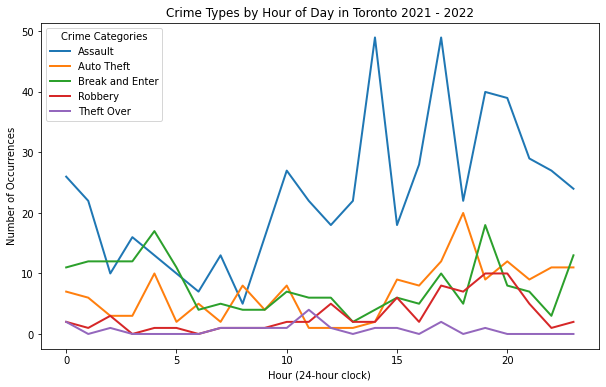

In [ ]:
# Group the data by occurrence hour and MCI, and count the number of occurrences
hour_crime_group = crime_data.groupby(['occurrencehour', 'mci_category']).size().reset_index(name='n')

# Plot a line graph to show the number of occurrences by crime type and hour of occurrence
fig, ax = plt.subplots(figsize=(10, 6))
for crime_type, group in hour_crime_group.groupby('mci_category'):
    ax.plot(group['occurrencehour'], group['n'], label=crime_type, linewidth=2)

# Set a legend with desired location and set title, x and y axes labels
ax.legend(title='Crime Categories', loc='upper left')
ax.set_title('Crime Types by Hour of Day in Toronto 2021 - 2022')
ax.set_xlabel('Hour (24-hour clock)')
ax.set_ylabel('Number of Occurrences')

# Plot the graph
plt.show()

#### **Discussion**
> The plot shows trend of different types of crimes across the day, and helps to identify peak hours when certain crimes are more likely to occur. 
>
> This data is valid for year 2021 till 2022.
> It's evident from the graph that most of the offences are more likely to occur during the night and early morning hours i.e. from 15:00 to 4:00.
> 
> Though, Assault and Auto Theft crimes are more common at evening which is the peak time for people going home. People using public transit, sidewalks, pedways etc. at these hours are more susceptible to Assault or theft.

> Creating two count plots using the *subplots()* function from matplotlib.  It shows the distribution of *Age_group* across different Sex categories in *arrests_data*.  The second subplot shows the distribution of *Age_group* across different *Arrest_Month* categories in *arrests_data*. The x-axis represents the *Arrest_Month* categories, and the bars are grouped by the *Age_group*.

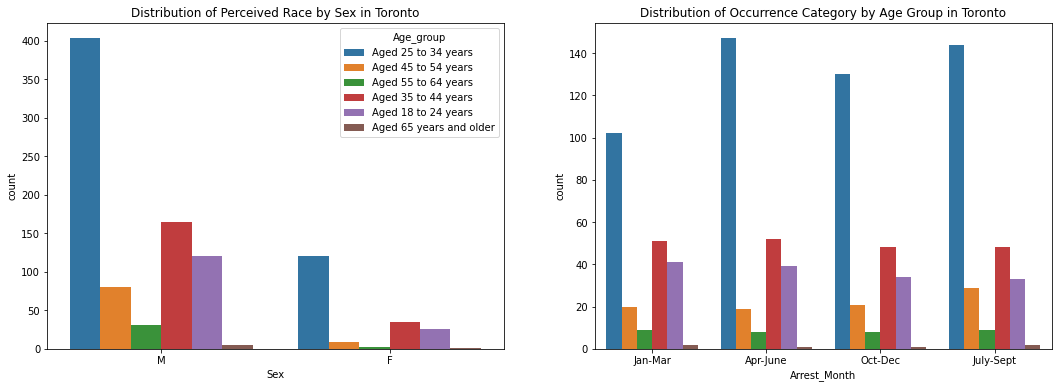

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first countplot in the first subplot
sns.countplot(x='Sex', hue='Age_group', data=arrests_data, ax=axes[0])
axes[0].set_title('Distribution of Perceived Race by Sex in Toronto')

# Plot the second countplot in the second subplot
sns.countplot(x='Arrest_Month', hue='Age_group', data=arrests_data, ax=axes[1])#, legend=False)
axes[1].set_title('Distribution of Occurrence Category by Age Group in Toronto')

# Remove the legend from the second subplot
axes[1].legend([], [], frameon=False)

# Show the figure
plt.show()

**Discussion**
> The sex considered is biological gender. The dataset might vary if LGBTQ+ is considered.
>
> In the first subplot, it can be observed that the majority of arrests in the dataset are males aged 25-34.
>
> The second subplot shows that the number of arrests is relatively consistent across months, with a slight increase during the summer and fall months. 
>
> The count of arrests is highest for the 25-34 age group followed by the 35-44 age group in both the subplots. Overall, the plots give an idea of the distribution of arrests across age, sex and month categories in the dataset.

## References




* [Exploratory Data Analysis (EDA)](https://medium.com/analytics-vidhya/descriptive-predictive-and-feature-selection-on-time-series-data-813a202312b1)

* [Exploratory Analysis of Vancouver Crime Data](https://www.kaggle.com/code/agilesifaka/exploratory-analysis-of-vancouver-crime-data/notebook) 

* [Exploring, Clustering and Mapping Toronto’s Crimes](https://towardsdatascience.com/exploring-clustering-and-mapping-torontos-crimes-96336efe490f)

* [Toronto Crime and Folium](https://www.jiristodulka.com/post/toronto-crime/)

* [Exploratory Data Analysis (EDA), Feature Selection, and machine learning prediction on time series data]( https://medium.com/analytics-vidhya/descriptive-predictive-and-feature-selection-on-time-series-data-813a202312b1)

### Data

 * [Major Crime Indicators (MCI)](https://data.torontopolice.on.ca/datasets/TorontoPS::major-crime-indicators-1/about)

 * [Arrests and Strip Searches (RBDC-ARR-TBL-001](https://data.torontopolice.on.ca/datasets/TorontoPS::arrests-and-strip-searches-rbdc-arr-tbl-001/about)